## Recall Task Plot

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os

%matplotlib inline

In [10]:
os.getcwd()

'/app/git/MANN/notebooks'

## Load training history

To generate the models and training history used in this notebook, run the following commands:

```
./main.py --seed 1    --task recall --checkpoint-interval 500 --checkpoint-path ./checkpoint/ntm-recall
./main.py --seed 10   --task recall --checkpoint-interval 500 --checkpoint-path ./checkpoint/ntm-recall
./main.py --seed 100  --task recall --checkpoint-interval 500 --checkpoint-path ./checkpoint/ntm-recall
./main.py --seed 1000 --task recall --checkpoint-interval 500 --checkpoint-path ./checkpoint/ntm-recall
```

In [ ]:
path = '../checkpoint/ntm-recall/'
batch_num = 100000
interval = 5000
files = glob(path + 'recall-*-{}.json'.format(batch_num))
files

In [13]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

['../checkpoint/ntm-recall/recall-task-100-batch-100000.json',
 '../checkpoint/ntm-recall/recall-task-1000-batch-100000.json',
 '../checkpoint/ntm-recall/recall-task-10-batch-100000.json',
 '../checkpoint/ntm-recall/recall-task-1-batch-100000.json']

In [14]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

Training history (seed x metric x sequence) = (4, 3, 100000)


In [15]:
# Average every dv values across each (seed, metric)
dv = 100
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(4, 3, 1000)


In [16]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 1000)
(3, 1000)


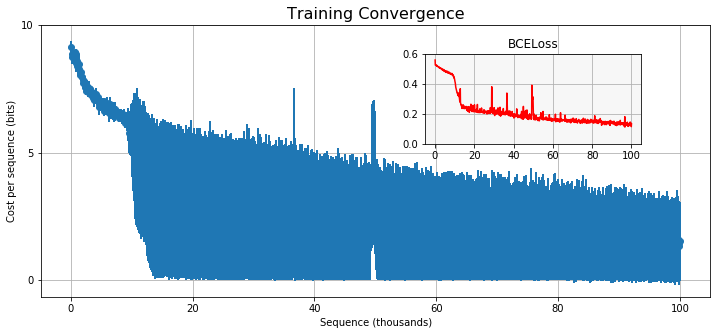

In [17]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

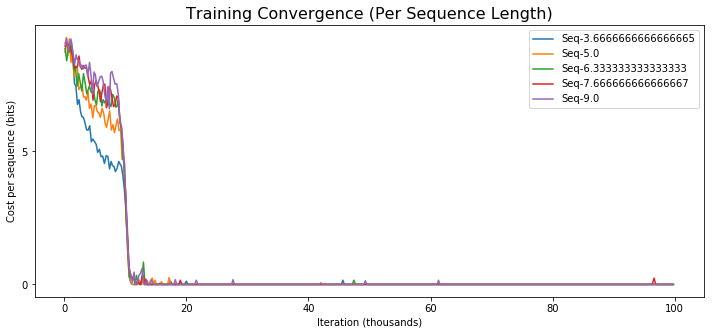

In [18]:
id = 0

loss = history[id]['loss']
cost = history[id]['cost']
seq_lengths = history[id]['repeat']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

plt.yticks(np.arange(0, 10, 5))
plt.legend(loc=0)
plt.show()

## Evalute

In [19]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from tasks.associativerecall_task import data_loader
from train import evaluate

In [20]:
from tasks.associativerecall_task import AssociativeRecallTaskModel
model = AssociativeRecallTaskModel()

In [21]:
seed = 1
# Initialize the Model]# Initialize the Model
model.net.load_state_dict(torch.load(path + 'recall-task-{}-batch-{}.model'.format(seed, batch_num)))

<All keys matched successfully>

In [22]:
seq_len = 10
_, x, y = next(iter(data_loader(1, 1, 6, 3, seq_len, seq_len, False)))
result = evaluate(model.net, model.criterion, x, y)
y_out = result['y_out']
cost = result['cost']

In [23]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j].item()
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(imgs, pad=8):
  w, h = imgs[0].size

  width = w
  height = (h + pad) * len(imgs)

  im = Image.new('L', (width, height), color=255)
  for i, img in enumerate(imgs):
    im.paste(img, (0, i*(h+pad)))
  return im

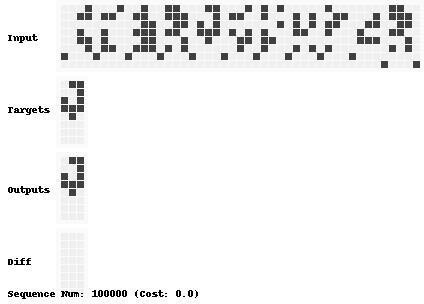

In [24]:
def make_eval_plot(y, y_out, u=12):
    im_x = draw_sequence(x, u)
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im_y_diff = draw_sequence(y_out - y, u)
    im = im_vconcat([im_x, im_y, im_y_out, im_y_diff], u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    # font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Input")#, font=font)
    draw.text((u,13*u), "Targets")#, font=font)
    draw.text((u,23*u), "Outputs")#, font=font)    
    draw.text((u,32*u), "Diff")#, font=font)
    draw.text((u,36*u), "Sequence Num: {} (Cost: {})".format(batch_num, result['cost']))

    return im2

im = make_eval_plot(y, y_out, u=8)

IPythonImage(im_to_png_bytes(im))

In [25]:
seq_len = 3
_, x, y = next(iter(data_loader(1, 1, 6, 3, 10, 10, False)))

frames = []
# font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
for batch_num in range(interval, batch_num + interval, interval):
    model = AssociativeRecallTaskModel()
    model.net.load_state_dict(torch.load(path + 'recall-task-{}-batch-{}.model'.format(seed, batch_num)))
    result = evaluate(model.net, model.criterion, x, y)
    y_out = result['y_out']
    frame = make_eval_plot(y, y_out, u=10)
    
    w, h = frame.size
    frame_seq = Image.new('L', (w, h+40), color=255)
    frame_seq.paste(frame, (0, 40))
    
    draw = ImageDraw.ImageDraw(frame_seq)
    draw.text((10, 10), "Sequence Num: {} (Cost: {})".format(batch_num, result['cost']))
    
    frames += [frame_seq]

In [26]:
im = frames[0]
im.save('./images/ntm-recall-train.gif', save_all=True, append_images=frames[1:], loop=0, duration=1000)

im = frames[0]
im.save('./images/ntm-recall-train-fast.gif', save_all=True, append_images=frames[1:], loop=0, duration=100)

![SegmentLocal](./images/ntm-recall-train.gif "ntm-recall")

![SegmentLocal](./images/ntm-recall-train-fast.gif "ntm-recall fast")
